In [1]:
# reload notebook automatically after changes to source python files
%load_ext autoreload
%autoreload 2

# change base folder to parent
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(os.getcwd())

import torch
torch.hub.set_dir('/scratch/toponav/indoor-topo-loc/checkpoints/torchhub')
print(torch.hub.get_dir())  

/home2/rjayanti/workdirs/rjayanti/kp2seg-evals
/scratch/toponav/indoor-topo-loc/checkpoints/torchhub


In [2]:
from pathlib import Path
from natsort import natsorted

import numpy as np

dataset_root = Path("/scratch/toponav/indoor-topo-loc/datasets/17Places")
ref_img_dir = dataset_root / "ref"
query_img_dir = dataset_root / "query"

ref_img_list = natsorted(list(ref_img_dir.glob("*.jpg")))
query_img_list = natsorted(list(query_img_dir.glob("*.jpg")))

# print the number of images in the reference and query directories
print(f"Number of reference images: {len(ref_img_list)}")
print(f"Number of query images: {len(query_img_list)}")

gt_file = dataset_root / "my_ground_truth_new.npy"
gt_data = np.load(gt_file, allow_pickle=True)
num_queries = len(gt_data)  # Assuming Q = R = 406

# Initialize the square matrix (Q x R) with zeros
gt_square_matrix = np.zeros((num_queries, num_queries), dtype=np.int32)

# Fill the matrix with 1s where matches exist
max_index = num_queries - 1 # 405 here
for query_idx, matched_indices in gt_data:
    # cull indices that are greater than max_index
    matched_indices = np.array([int(idx) for idx in matched_indices if idx <= max_index], dtype=np.int16)
    gt_square_matrix[matched_indices, query_idx] = 1 # (ref, query) as (row, column)
    
# Print the shape and a small part of the matrix
print(gt_square_matrix.shape)  # Should be (406, 406)

Number of reference images: 406
Number of query images: 406
(406, 406)


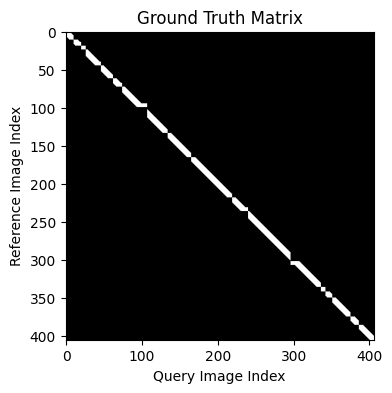

In [3]:
# plot the ground truth matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(gt_square_matrix, cmap='gray')

plt.title("Ground Truth Matrix")
plt.xlabel("Query Image Index")
plt.ylabel("Reference Image Index")
plt.show()

/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/rjayanti/miniconda3/envs/mast3r/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


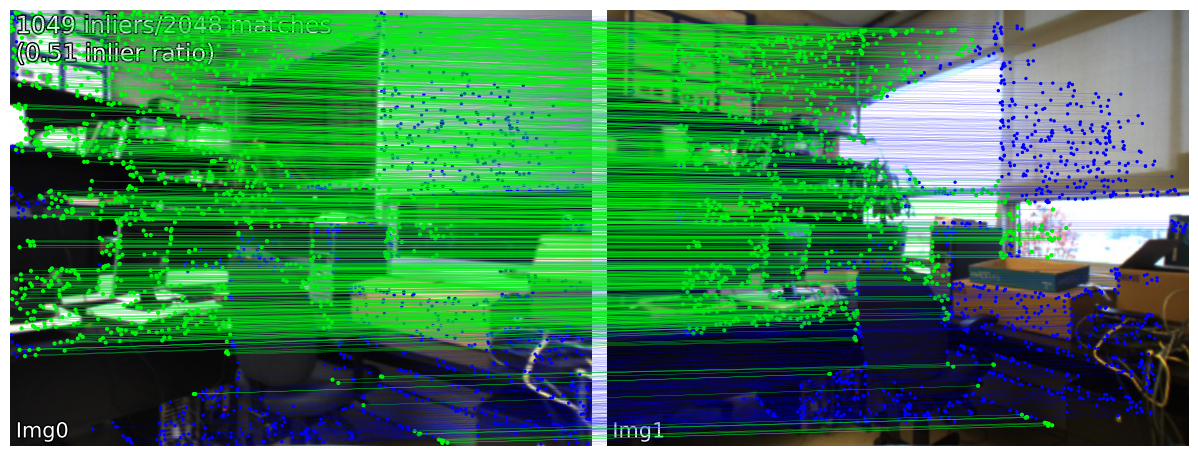

In [4]:
from matching import get_matcher
from matching.viz import plot_matches

device = 'cuda'  # 'cpu'
matcher = get_matcher('roma', device=device)

TEST_INDEX = 12
img0 = matcher.load_image(str(ref_img_list[TEST_INDEX]))
img1 = matcher.load_image(str(query_img_list[TEST_INDEX]))

result = matcher(img0, img1)

# num_inliers, inlier_kpts0, inlier_kpts1 = result['num_inliers'], result['inlier_kpts0'], result['inlier_kpts1']
# # result.keys() = ['num_inliers', 'H', 'all_kpts0', 'all_kpts1', 'all_desc0', 'all_desc1', 'matched_kpts0', 'matched_kpts1', 'inlier_kpts0', 'inlier_kpts1']
plot_matches(img0, img1, result, save_path=None)